# Train an ImageNet to classify the ISIC 2024 Data / Generate OOF Preds
* This is a (detuned) public version of my notebook intended to demonstrate how to generate OOF preds for use by LGBM
* Idea is to show how this works (it will probably not produce a rocking LB score)
* This notebook will predicts on test using an average of all folds
* It will also output the models / oof_predictions.csv for easy integration with LGBM / similar...

* For an example of how to use see https://www.kaggle.com/code/richolson/isic-2024-borrowed-179lb-tabular-oof-imagenet/notebook

* Note: There is a bunch of redundant code here (intent is to make sharing with other notebooks easier)

In [6]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.9 MB/s eta 0:00:00a 0:00:01


In [117]:
import os
import random
import time
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import io
import h5py

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm

from sklearn.metrics import hamming_loss, f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import binarize
from sklearn.model_selection import GroupShuffleSplit

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

# Misc. Setup

In [118]:
project_dir = os.path.join('materials', 'ISIC-2024_CS640')
IMAGE_PATH = os.path.join(project_dir, 'train_image')

In [119]:

# from PIL import Image
# import h5py

# # Folder containing the images
# image_folder = IMAGE_PATH
# output_h5py_file = os.path.join(project_dir, "output_images.h5")

# # Set the target image size (e.g., for models like Inception or MobileNet)
# image_size = (224, 224)  # Resize all images to this size

# # Collect image data and labels
# image_data = []
# image_labels = []  # If you have labels (e.g., based on subfolders)

# # Iterate through the folder
# for root, _, files in os.walk(image_folder):
#     for file in files:
#         if file.endswith((".png", ".jpg", ".jpeg")):
#             # Load the image
#             img_path = os.path.join(root, file)
#             img = Image.open(img_path).convert('RGB')  # Convert to RGB
#             img = img.resize(image_size)  # Resize image
#             img_array = np.array(img, dtype=np.float16) / 255.0  # Normalize to [0, 1]
#             image_data.append(img_array)

#             # If labels are subfolders, extract the folder name as a label
#             label = os.path.basename(root)
#             image_labels.append(label)

# # Convert to numpy arrays
# image_data = np.array(image_data)
# image_labels = np.array(image_labels)  # Optional

# # Map labels to integers if necessary
# unique_labels = np.unique(image_labels)
# label_map = {label: idx for idx, label in enumerate(unique_labels)}
# encoded_labels = np.array([label_map[label] for label in image_labels])

# # Save to HDF5
# with h5py.File(output_h5py_file, "w") as hf:
#     hf.create_dataset("images", data=image_data, compression="gzip")  # Compress for efficiency
#     hf.create_dataset("labels", data=encoded_labels, compression="gzip")  # Save labels if available

# print(f"Images and labels saved to {output_h5py_file}")

In [120]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
#number of epochs to train for
num_epochs = 5

#train entire model vs. just the classifier
freeze_base_model = False  #didn't get good results

# if this is set to true - full model is only generated as part of scoring (quick_train_record_count used)
# this saves GPU quota - but saved model won't reflect what was scored...
full_train_only_when_scoring = False  #must be False to save full model!
quick_train_record_count = 50000   #need to get at least some positive cases even for test run

Using device: cuda
GPU: NVIDIA L40S
Number of GPUs: 1


# Load meta - and split folds
* Maintain consistency with tabular data in other notebooks

In [150]:
df_train = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
print(df_train['tbp_lv_location'].unique())
# for i in df_train.columns:
#     print(i)
# df_train['patient_id'] = [i % 1024 for i in range(len(df_train))]
# # for i in len(df_train):
# #     df_train['patient_id'][i] = i % 1024
# print(df_train['patient_id'])

['Left Arm - Lower' 'Torso Back Middle Third' 'Left Leg - Upper'
 'Torso Back Top Third' 'Torso Front Top Half' 'Left Arm - Upper'
 'Left Leg - Lower' 'Torso Front Bottom Half' 'Head & Neck'
 'Right Arm - Upper' 'Right Leg - Upper' 'Right Leg - Lower'
 'Right Arm - Lower' 'Left Leg' 'Torso Back Bottom Third' 'Unknown'
 'Right Leg' 'Left Arm' 'Torso Back' 'Right Arm' 'Torso Front']


In [126]:
print(df_train[df_train['id'] == 0])
df_train[df_train['id'] == 0]

   id  target  age_approx   sex anatom_site_general  clin_size_long_diam_mm  \
0   0       0        55.0  male     upper extremity                    2.58   

  tbp_tile_type  tbp_lv_A  tbp_lv_Aext  tbp_lv_B  ...  tbp_lv_norm_color  \
0     3D: white  21.98961     18.14972  26.13898  ...           3.207238   

   tbp_lv_perimeterMM  tbp_lv_radial_color_std_max  tbp_lv_stdL  \
0            7.162229                     1.181736     2.552678   

   tbp_lv_stdLExt  tbp_lv_symm_2axis  tbp_lv_symm_2axis_angle  tbp_lv_x  \
0        2.169827               0.23                       45 -439.3386   

   tbp_lv_y  tbp_lv_z  
0  1230.412  22.64789  

[1 rows x 41 columns]


,id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,0,55.0,male,upper extremity,2.58,3D: white,21.98961,18.14972,26.13898,...,3.207238,7.162229,1.181736,2.552678,2.169827,0.23,45,-439.3386,1230.412,22.64789


In [129]:
from sklearn.model_selection import StratifiedKFold

num_folds = 5
# gkf = GroupKFold(n_splits=num_folds)
skf = StratifiedKFold(n_splits=5)


df_train["fold"] = -1
# for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
for idx, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["target"])):
    df_train.loc[val_idx, "fold"] = idx

# # Add summary
# # fold_summary = df_train.groupby("fold").to_dict()
# # total_patients = df_train["patient_id"].nunique()


# print(f"Fold Summary (patients per fold):")
# for fold, count in fold_summary.items():
#     if fold != -1:  # Exclude the initialization value
#         print(f"Fold {fold}: {count} patients")
# # print(f"Total patients: {total_patients}")
# print(df_train['id'])

# Load meta data / review

In [131]:
# Set the HDF5 file path
# TRAIN_HDF5_FILE_PATH = os.path.join(project_dir, "output_images.h5")

# are we scoring?
scoring = False
#check length of test data to see if we are scoring....
test_length = len(pd.read_csv(os.path.join(project_dir, "train_metadata.csv")))
print(test_length)
if test_length > 3:
    scoring = True

if not scoring:
    if full_train_only_when_scoring:
        df_train = df_train.head(quick_train_record_count)
                
print("\nOriginal Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
# print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")

320847

Original Dataset Summary:
Total number of samples: 320847
Number of positive cases: 314
Number of negative cases: 320533
Ratio of negative to positive cases: 1020.81:1


# Downsample Negatives / Keep All Positives
* Keeping just 1% of negatives!
* We only use a small subset of the data in each fold for training...

In [132]:
#keep all positives
df_target_1 = df_train[df_train['target'] == 1]

#just use 1% of negatives
df_target_0 = df_train[df_train['target'] == 0].sample(frac=0.01, random_state=42)

df_train_balanced = pd.concat([df_target_1, df_target_0]).reset_index(drop=True)

# Print balanced dataset summary
print("Balanced Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
# print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

positive_cases = df_train_balanced['target'].sum()
total_cases = len(df_train_balanced)
positive_ratio = positive_cases / total_cases

print(f"Number of positive cases: {positive_cases}")
print(f"Number of negative cases: {total_cases - positive_cases}")
print(f"New ratio of negative to positive cases: {(total_cases - positive_cases) / positive_cases:.2f}:1")

Balanced Dataset Summary:
Total number of samples: 320847
Number of positive cases: 314
Number of negative cases: 3205
New ratio of negative to positive cases: 10.21:1


# ImageNet Setup for Training

In [133]:
def setup_model(num_classes=2, freeze_base_model=freeze_base_model):
    model = timm.create_model('tf_efficientnetv2_b1', 
                            checkpoint_path='./Training_Results/Cheat/tf_efficientnetv2_b1-be6e41b0.pth',
                            pretrained=False)
    # model = timm.create_model('tf_efficientnetv2_b1', 
    #                             pretrained=True)

    if freeze_base_model:
        for param in model.parameters():
            param.requires_grad = False

    model.classifier = nn.Linear(model.classifier.in_features, out_features=num_classes)
    return model.to(device)    

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

# Data Loading / Image Augmentation

In [134]:
from torchvision.io import read_image



class ISICDataset(Dataset):
    # def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
    def __init__(self, df, isic_ids, targets=None, transform=None):
        self.df = df
        # self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    # def __getitem__(self, idx):
    #     with h5py.File(self.hdf5_file, 'r') as f:
    #         img_bytes = f[self.isic_ids[idx]][()]
        
    #     img = Image.open(io.BytesIO(img_bytes))
    #     img = np.array(img)  # Convert PIL Image to numpy array
        
    #     if self.transform:
    #         transformed = self.transform(image=img)
    #         img = transformed['image']
        
    #     if self.targets is not None:
    #         target = self.targets[idx]
    #     else:
    #         target = torch.tensor(-1)  # Dummy target for test set
            
    #     return img, target
    
    def __getitem__(self, idx):
        # print(self.df[self.df['id'] == idx]['filename'].values[0])
        img = read_image(self.df[self.df['id'] == idx]['filename'].values[0])
        
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        # print(img.shape)
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
            # print(img.shape)
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/scratch/1443786.1.l40s/ipykernel_410585/470781371.py:57: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


# Visualize image augmentation

In [135]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

def visualize_augmentations_positive(dataset, num_samples=3, num_augmentations=5, figsize=(20, 10)):
    # Find positive samples
    positive_samples = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 1:  # Assuming 1 is the positive class
            positive_samples.append(i)

        if len(positive_samples) == num_samples:
            break
    
    if len(positive_samples) < num_samples:
        print(f"Warning: Only found {len(positive_samples)} positive samples.")
    
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=figsize)
    fig.suptitle("Original and Augmented Versions of Positive Samples", fontsize=16)

    for sample_num, sample_idx in enumerate(positive_samples):
        # Get a single sample
        original_image, label = dataset[sample_idx]
        
        # If the image is already a tensor (due to ToTensorV2 in the transform), convert it back to numpy
        if isinstance(original_image, torch.Tensor):
            # print(original_image.shape)
            original_image = original_image.permute(1, 2, 0).numpy()

        
        # Reverse the normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_image = (original_image * std + mean) * 255
        original_image = original_image.astype(np.uint8)

        # Display original image
        axes[sample_num, 0].imshow(original_image)
        axes[sample_num, 0].axis('off')
        axes[sample_num, 0].set_title("Original", fontsize=10)

        # Apply and display augmentations
        for aug_num in range(num_augmentations):
            augmented = dataset.transform(image=original_image)['image']
            # If the result is a tensor, convert it back to numpy
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.permute(1, 2, 0).numpy()
            # Reverse the normalization
            augmented = (augmented * std + mean) * 255
            augmented = augmented.astype(np.uint8)
            
            axes[sample_num, aug_num + 1].imshow(augmented)
            axes[sample_num, aug_num + 1].axis('off')
            axes[sample_num, aug_num + 1].set_title(f"Augmented {aug_num + 1}", fontsize=10)

    plt.tight_layout()
    plt.show()

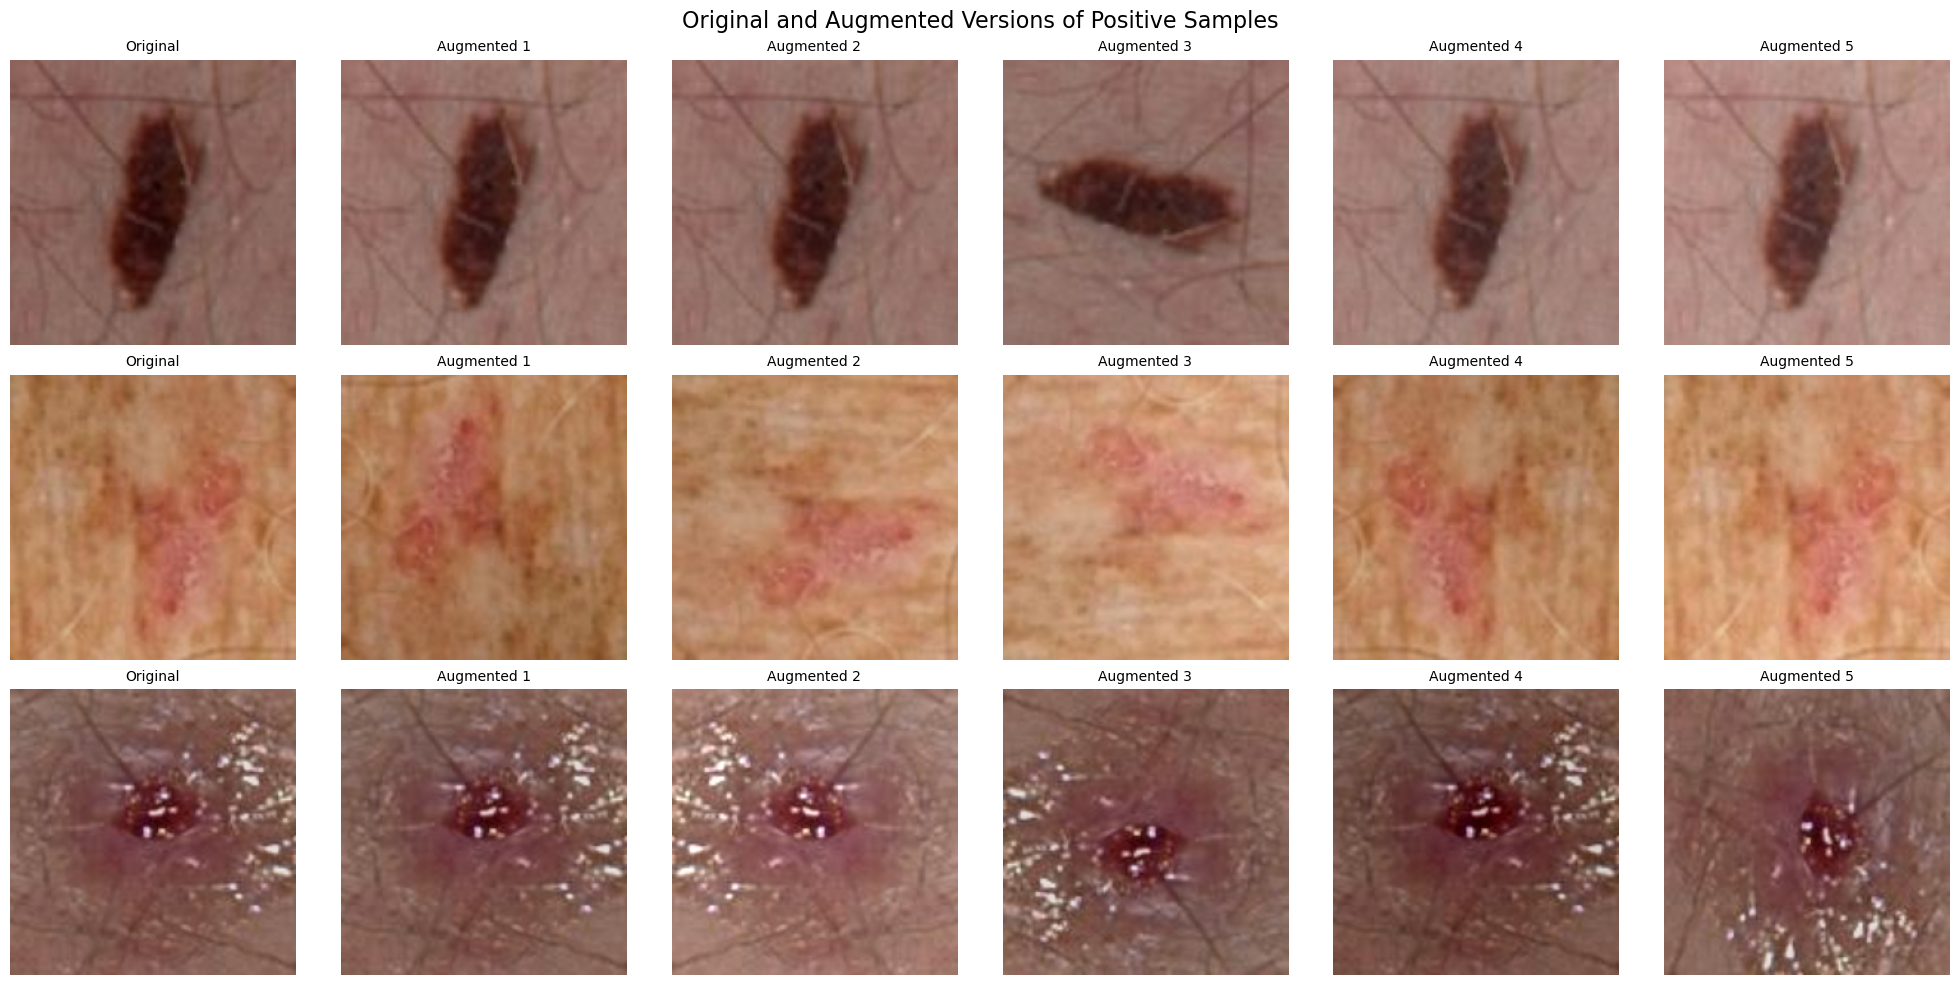

In [136]:


##Customized###

TRAIN_PATH = os.path.join(project_dir, 'train_image')
data_df = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
data_df['target'] = data_df['target'].astype(np.int32)
data_df['filename'] = data_df['id'].apply(lambda x: os.path.join(TRAIN_PATH, f"{x}.jpg"))


augtest_dataset = ISICDataset(
                    df = data_df,
                    isic_ids=df_train['id'].values,
                    targets=df_train['target'].values,
                    transform=aug_transform,
                )

# print(augtest_dataset.head
#############

# augtest_dataset = ISICDataset(
#     hdf5_file=TRAIN_HDF5_FILE_PATH,
#     isic_ids=df_train['id'].values,
#     targets=df_train['target'].values,
#     transform=aug_transform,
# )

visualize_augmentations_positive(augtest_dataset)

# Scoring code from https://www.kaggle.com/code/metric/isic-pauc-abovetpr

In [137]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

# Train / CV

In [140]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np

def train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device):
    scaler = GradScaler()
    
    # Training phase
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Evaluation phase
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad(), autocast():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_targets.append(targets.cpu())
            val_outputs.append(outputs.softmax(dim=1)[:, 1].cpu())
    
    scheduler.step()
    return torch.cat(val_targets).numpy(), torch.cat(val_outputs).numpy()


def cross_validation_train(df_train, num_folds, num_epochs, data_df, aug_transform, base_transform, device):
    criterion = nn.CrossEntropyLoss()
    all_val_targets, all_val_outputs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_val_targets, epoch_val_outputs = [], []

        for fold in range(num_folds):
            print(f"\nFold {fold + 1}/{num_folds}")
            
            # Split data for current fold
            train_df = df_train[df_train['fold'] != fold]
            val_df = df_train[df_train['fold'] == fold]
            
            # Create datasets and data loaders
            train_dataset = ISICDataset(data_df, train_df['id'].values, train_df['target'].values, aug_transform)
            val_dataset = ISICDataset(data_df, val_df['id'].values, val_df['target'].values, base_transform)
            
            train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)
            
            # Initialize model, optimizer, and scheduler
            model = setup_model().to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
            
            print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, "
                  f"Train Pos Ratio: {train_df['target'].mean():.2%}, Val Pos Ratio: {val_df['target'].mean():.2%}")
            
            # Train and evaluate
            val_targets, val_outputs = train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device)
            epoch_val_targets.extend(val_targets)
            epoch_val_outputs.extend(val_outputs)
            
            torch.save(model.state_dict(), f'model_fold_{fold}_epoch_{epoch + 1}.pth')
            
            # Create DataFrames with row_id for scoring
            solution_df = pd.DataFrame({'target': val_targets, 'row_id': range(len(val_targets))})
            submission_df = pd.DataFrame({'prediction': val_outputs, 'row_id': range(len(val_outputs))})
            fold_score = score(solution_df, submission_df, 'row_id')
            print(f'Fold {fold + 1} pAUC Score: {fold_score:.4f}')
        
        all_val_targets.extend(epoch_val_targets)
        all_val_outputs.extend(epoch_val_outputs)
        
        # Create DataFrames with row_id for scoring
        solution_df = pd.DataFrame({'target': epoch_val_targets, 'row_id': range(len(epoch_val_targets))})
        submission_df = pd.DataFrame({'prediction': epoch_val_outputs, 'row_id': range(len(epoch_val_outputs))})
        cv_score = score(solution_df, submission_df, 'row_id')
        print(f'Epoch {epoch + 1}/{num_epochs} CV pAUC Score: {cv_score:.4f}')

    return np.array(all_val_targets), np.array(all_val_outputs)

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Perform cross-validation training
all_val_targets, all_val_outputs = cross_validation_train(df_train_balanced, num_folds, num_epochs, data_df, aug_transform, base_transform, device)

/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using device: cuda

Epoch 1/5

Fold 1/5
Train: 2830, Val: 689, Train Pos Ratio: 8.87%, Val Pos Ratio: 9.14%


Epoch 1, Fold 1 Training:   0%|          | 0/708 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1, Fold 1 Training: 100%|██████████| 708/708 [00:17<00:00, 41.45it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1, Fold 1 Evaluating: 100%|██████████| 173/173 [00:01<00:00, 100.11it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0149

Fold 2/5
Train: 2814, Val: 705, Train Pos Ratio: 8.92%, Val Pos Ratio: 8.94%


Epoch 1, Fold 2 Training:   0%|          | 0/704 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1, Fold 2 Training: 100%|██████████| 704/704 [00:16<00:00, 42.09it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1, Fold 2 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 116.85it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0258

Fold 3/5
Train: 2798, Val: 721, Train Pos Ratio: 9.01%, Val Pos Ratio: 8.60%


Epoch 1, Fold 3 Training:   0%|          | 0/700 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1, Fold 3 Training: 100%|██████████| 700/700 [00:16<00:00, 43.72it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1, Fold 3 Evaluating: 100%|██████████| 181/181 [00:01<00:00, 111.99it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0267

Fold 4/5
Train: 2822, Val: 697, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.04%


Epoch 1, Fold 4 Training:   0%|          | 0/706 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1, Fold 4 Training: 100%|██████████| 706/706 [00:15<00:00, 44.25it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1, Fold 4 Evaluating: 100%|██████████| 175/175 [00:01<00:00, 116.65it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0235

Fold 5/5
Train: 2812, Val: 707, Train Pos Ratio: 8.93%, Val Pos Ratio: 8.91%


Epoch 1, Fold 5 Training:   0%|          | 0/703 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1, Fold 5 Training: 100%|██████████| 703/703 [00:16<00:00, 42.99it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1, Fold 5 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 104.16it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0141
Epoch 1/5 CV pAUC Score: 0.0197

Epoch 2/5

Fold 1/5
Train: 2830, Val: 689, Train Pos Ratio: 8.87%, Val Pos Ratio: 9.14%


Epoch 2, Fold 1 Training:   0%|          | 0/708 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2, Fold 1 Training: 100%|██████████| 708/708 [00:16<00:00, 43.55it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 2, Fold 1 Evaluating: 100%|██████████| 173/173 [00:01<00:00, 115.40it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0270

Fold 2/5
Train: 2814, Val: 705, Train Pos Ratio: 8.92%, Val Pos Ratio: 8.94%


Epoch 2, Fold 2 Training:   0%|          | 0/704 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2, Fold 2 Training: 100%|██████████| 704/704 [00:16<00:00, 43.30it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 2, Fold 2 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 108.57it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0198

Fold 3/5
Train: 2798, Val: 721, Train Pos Ratio: 9.01%, Val Pos Ratio: 8.60%


Epoch 2, Fold 3 Training:   0%|          | 0/700 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2, Fold 3 Training: 100%|██████████| 700/700 [00:17<00:00, 39.45it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 2, Fold 3 Evaluating: 100%|██████████| 181/181 [00:01<00:00, 104.17it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0240

Fold 4/5
Train: 2822, Val: 697, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.04%


Epoch 2, Fold 4 Training:   0%|          | 0/706 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2, Fold 4 Training: 100%|██████████| 706/706 [00:16<00:00, 41.95it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 2, Fold 4 Evaluating: 100%|██████████| 175/175 [00:01<00:00, 116.72it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0240

Fold 5/5
Train: 2812, Val: 707, Train Pos Ratio: 8.93%, Val Pos Ratio: 8.91%


Epoch 2, Fold 5 Training:   0%|          | 0/703 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2, Fold 5 Training: 100%|██████████| 703/703 [00:15<00:00, 44.41it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 2, Fold 5 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 116.51it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0219
Epoch 2/5 CV pAUC Score: 0.0205

Epoch 3/5

Fold 1/5
Train: 2830, Val: 689, Train Pos Ratio: 8.87%, Val Pos Ratio: 9.14%


Epoch 3, Fold 1 Training:   0%|          | 0/708 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3, Fold 1 Training: 100%|██████████| 708/708 [00:16<00:00, 43.78it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 3, Fold 1 Evaluating: 100%|██████████| 173/173 [00:01<00:00, 111.59it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0252

Fold 2/5
Train: 2814, Val: 705, Train Pos Ratio: 8.92%, Val Pos Ratio: 8.94%


Epoch 3, Fold 2 Training:   0%|          | 0/704 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3, Fold 2 Training: 100%|██████████| 704/704 [00:16<00:00, 41.84it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 3, Fold 2 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 117.76it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0203

Fold 3/5
Train: 2798, Val: 721, Train Pos Ratio: 9.01%, Val Pos Ratio: 8.60%


Epoch 3, Fold 3 Training:   0%|          | 0/700 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3, Fold 3 Training: 100%|██████████| 700/700 [00:16<00:00, 43.49it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 3, Fold 3 Evaluating: 100%|██████████| 181/181 [00:01<00:00, 113.71it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0284

Fold 4/5
Train: 2822, Val: 697, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.04%


Epoch 3, Fold 4 Training:   0%|          | 0/706 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3, Fold 4 Training: 100%|██████████| 706/706 [00:16<00:00, 44.09it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 3, Fold 4 Evaluating: 100%|██████████| 175/175 [00:01<00:00, 113.86it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0303

Fold 5/5
Train: 2812, Val: 707, Train Pos Ratio: 8.93%, Val Pos Ratio: 8.91%


Epoch 3, Fold 5 Training:   0%|          | 0/703 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3, Fold 5 Training: 100%|██████████| 703/703 [00:16<00:00, 42.22it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 3, Fold 5 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 109.10it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0186
Epoch 3/5 CV pAUC Score: 0.0223

Epoch 4/5

Fold 1/5
Train: 2830, Val: 689, Train Pos Ratio: 8.87%, Val Pos Ratio: 9.14%


Epoch 4, Fold 1 Training:   0%|          | 0/708 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4, Fold 1 Training: 100%|██████████| 708/708 [00:16<00:00, 44.20it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 4, Fold 1 Evaluating: 100%|██████████| 173/173 [00:01<00:00, 117.06it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0251

Fold 2/5
Train: 2814, Val: 705, Train Pos Ratio: 8.92%, Val Pos Ratio: 8.94%


Epoch 4, Fold 2 Training:   0%|          | 0/704 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4, Fold 2 Training: 100%|██████████| 704/704 [00:15<00:00, 44.37it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 4, Fold 2 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 117.84it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0270

Fold 3/5
Train: 2798, Val: 721, Train Pos Ratio: 9.01%, Val Pos Ratio: 8.60%


Epoch 4, Fold 3 Training:   0%|          | 0/700 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4, Fold 3 Training: 100%|██████████| 700/700 [00:16<00:00, 43.41it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 4, Fold 3 Evaluating: 100%|██████████| 181/181 [00:01<00:00, 111.69it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0160

Fold 4/5
Train: 2822, Val: 697, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.04%


Epoch 4, Fold 4 Training:   0%|          | 0/706 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4, Fold 4 Training: 100%|██████████| 706/706 [00:16<00:00, 42.13it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 4, Fold 4 Evaluating: 100%|██████████| 175/175 [00:01<00:00, 116.93it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0249

Fold 5/5
Train: 2812, Val: 707, Train Pos Ratio: 8.93%, Val Pos Ratio: 8.91%


Epoch 4, Fold 5 Training:   0%|          | 0/703 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4, Fold 5 Training: 100%|██████████| 703/703 [00:16<00:00, 43.89it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 4, Fold 5 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 116.18it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0173
Epoch 4/5 CV pAUC Score: 0.0189

Epoch 5/5

Fold 1/5
Train: 2830, Val: 689, Train Pos Ratio: 8.87%, Val Pos Ratio: 9.14%


Epoch 5, Fold 1 Training:   0%|          | 0/708 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5, Fold 1 Training: 100%|██████████| 708/708 [00:16<00:00, 43.58it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 5, Fold 1 Evaluating: 100%|██████████| 173/173 [00:01<00:00, 118.38it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0245

Fold 2/5
Train: 2814, Val: 705, Train Pos Ratio: 8.92%, Val Pos Ratio: 8.94%


Epoch 5, Fold 2 Training:   0%|          | 0/704 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5, Fold 2 Training: 100%|██████████| 704/704 [00:16<00:00, 41.81it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 5, Fold 2 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 112.74it/s]


Fold 2 pAUC Score: 0.0231

Fold 3/5


/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 2798, Val: 721, Train Pos Ratio: 9.01%, Val Pos Ratio: 8.60%


Epoch 5, Fold 3 Training:   0%|          | 0/700 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5, Fold 3 Training: 100%|██████████| 700/700 [00:16<00:00, 43.64it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 5, Fold 3 Evaluating: 100%|██████████| 181/181 [00:01<00:00, 113.32it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0188

Fold 4/5
Train: 2822, Val: 697, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.04%


Epoch 5, Fold 4 Training:   0%|          | 0/706 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5, Fold 4 Training: 100%|██████████| 706/706 [00:16<00:00, 43.80it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 5, Fold 4 Evaluating: 100%|██████████| 175/175 [00:01<00:00, 116.84it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0138

Fold 5/5
Train: 2812, Val: 707, Train Pos Ratio: 8.93%, Val Pos Ratio: 8.91%


Epoch 5, Fold 5 Training:   0%|          | 0/703 [00:00<?, ?it/s]/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5, Fold 5 Training: 100%|██████████| 703/703 [00:16<00:00, 43.10it/s]
/scratch/1443786.1.l40s/ipykernel_410585/971549762.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 5, Fold 5 Evaluating: 100%|██████████| 177/177 [00:01<00:00, 110.06it/s]

Fold 5 pAUC Score: 0.0128
Epoch 5/5 CV pAUC Score: 0.0178


In [141]:
# Final overall evaluation
print("\nFinal Overall Evaluation:")

# Calculate the official pAUC score
solution_df = pd.DataFrame({'target': all_val_targets, 'row_id': range(len(all_val_targets))})
submission_df = pd.DataFrame({'prediction': all_val_outputs, 'row_id': range(len(all_val_outputs))})
official_score = score(solution_df, submission_df, 'row_id')
print(f'Overall pAUC Score: {official_score:.4f}')

# Generate and print classification report
binary_predictions = binarize(np.array(all_val_outputs).reshape(-1, 1), threshold=0.5).reshape(-1)
report = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'])
print("\nOverall Classification Report:")
print(report)

# Print specific metrics for Class 1
report_dict = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'], output_dict=True, zero_division=0)
print(f"\nClass 1 Metrics:")
print(f"Precision: {report_dict['Class 1']['precision']:.4f}")
print(f"Recall: {report_dict['Class 1']['recall']:.4f}")
print(f"F1-score: {report_dict['Class 1']['f1-score']:.4f}")


Final Overall Evaluation:
Overall pAUC Score: 0.0204

Overall Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95     16025
     Class 1       0.00      0.00      0.00      1570

    accuracy                           0.91     17595
   macro avg       0.46      0.50      0.48     17595
weighted avg       0.83      0.91      0.87     17595


Class 1 Metrics:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/share/pkg.8/academic-ml/fall-2024/install/fall-2024-pyt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-pyt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-pyt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

# Inference Code
* There are some duplicate definitions / includes here to make copying to other notebooks easier

In [142]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from torchvision import transforms
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = 5
model_path = ""

from torchvision.io import read_image



class ISICDataset(Dataset):
    # def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
    def __init__(self, df, isic_ids, targets=None, transform=None):
        self.df = df
        # self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    # def __getitem__(self, idx):
    #     with h5py.File(self.hdf5_file, 'r') as f:
    #         img_bytes = f[self.isic_ids[idx]][()]
        
    #     img = Image.open(io.BytesIO(img_bytes))
    #     img = np.array(img)  # Convert PIL Image to numpy array
        
    #     if self.transform:
    #         transformed = self.transform(image=img)
    #         img = transformed['image']
        
    #     if self.targets is not None:
    #         target = self.targets[idx]
    #     else:
    #         target = torch.tensor(-1)  # Dummy target for test set
            
    #     return img, target
    
    def __getitem__(self, idx):
        # print(self.df[self.df['id'] == idx]['filename'].values[0])
        img = read_image(self.df[self.df['id'] == idx]['filename'].values[0])
        
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        # print(img.shape)
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
            # print(img.shape)
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device)
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device))
        model.eval()
        models.append(model)
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


/scratch/1443786.1.l40s/ipykernel_410585/4109853181.py:74: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


# Generate out-of-fold predictions for Train
* Only done if not being submitted

In [144]:
def generate_oof_predictions(df_train, folds, data_df, transform):
    oof_predictions = np.zeros(len(df_train))
    model_filenames = [''] * len(df_train)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = load_models(folds, device)

    for fold in folds:
        print(f"Generating predictions for fold {fold + 1}/{num_folds}")
        val_df = df_train[df_train['fold'] == fold].copy()
        val_dataset = ISICDataset(data_df, val_df['id'].values, val_df['target'].values, transform)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=0, pin_memory=True)
        
        fold_predictions = ensemble_predict([models[fold]], val_loader, device)
        
        oof_predictions[val_df.index] = fold_predictions
        model_filename = f'model_fold_{fold}_epoch_1.pth'
        for idx in val_df.index:
            model_filenames[idx] = model_filename

    return oof_predictions, model_filenames

scoring = False
if not scoring:
    # Set up CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the number of folds
    folds = [0, 1, 2, 3, 4]

    # Generate out-of-fold predictions
    oof_predictions, model_filenames = generate_oof_predictions(df_train, folds, data_df, base_transform)

    

Using device: cuda


/scratch/1443786.1.l40s/ipykernel_410585/4109853181.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epo

Generating predictions for fold 1/5


Predicting: 100%|██████████| 126/126 [02:37<00:00,  1.25s/it]


Generating predictions for fold 2/5


Predicting: 100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Generating predictions for fold 3/5


Predicting: 100%|██████████| 126/126 [01:55<00:00,  1.09it/s]


Generating predictions for fold 4/5


Predicting: 100%|██████████| 126/126 [01:53<00:00,  1.11it/s]


Generating predictions for fold 5/5


Predicting: 100%|██████████| 126/126 [02:02<00:00,  1.03it/s]


KeyError: 'isic_id'

In [147]:
# Create DataFrame for OOF predictions
oof_df = pd.DataFrame({
    'isic_id': df_train['id'],
    'target': df_train['target'],
    'fold': df_train['fold'],
    'oof_prediction': oof_predictions,
    'model_filename': model_filenames
})

# Save OOF predictions to CSV
oof_df.to_csv('./Training_Results/Cheat/oof_predictions_v1.csv', index=False)
print("Out-of-fold predictions saved to oof_predictions_v1.csv")
print(oof_df)

Out-of-fold predictions saved to oof_predictions_v1.csv
        isic_id  target  fold  oof_prediction            model_filename
0             0       0     0        0.378965  model_fold_0_epoch_1.pth
1             1       0     0        0.002783  model_fold_0_epoch_1.pth
2             2       0     0        0.158954  model_fold_0_epoch_1.pth
3             3       0     0        0.384174  model_fold_0_epoch_1.pth
4             4       0     0        0.306280  model_fold_0_epoch_1.pth
...         ...     ...   ...             ...                       ...
320842   320842       0     4        0.065836  model_fold_4_epoch_1.pth
320843   320843       0     4        0.070322  model_fold_4_epoch_1.pth
320844   320844       0     4        0.067263  model_fold_4_epoch_1.pth
320845   320845       0     4        0.259262  model_fold_4_epoch_1.pth
320846   320846       0     4        0.081011  model_fold_4_epoch_1.pth

[320847 rows x 5 columns]


# Predict for test

In [14]:
df_test = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
TEST_HDF5_FILE_PATH = '/kaggle/input/isic-2024-challenge/test-image.hdf5'

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    hdf5_file=TEST_HDF5_FILE_PATH,
    isic_ids=df_test['isic_id'].values,
    transform=base_transform,
)    

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'isic_id': df_test['isic_id'],
    'target': predictions
})

# Save predictions to CSV
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")
print(submission_df.head())

Using device: cuda


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

Predictions saved to submission.csv
        isic_id    target
0  ISIC_0015657  0.057628
1  ISIC_0015729  0.003957
2  ISIC_0015740  0.097699
